In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import random
import  scipy.io
import torch
from torch.nn.functional import conv2d

In [2]:
train_x=np.load("task3_data/train_x.npy")
train_y=np.load("task3_data/train_y.npy")
test_x=np.load("task3_data/test_x.npy")
test_y=np.load("task3_data/test_y.npy")
#train_x=train_x.reshape(train_x.shape[0],train_x.shape[1]*train_x.shape[2])
#test_x=test_x.reshape(test_x.shape[0],test_x.shape[1]*test_x.shape[2])
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [3]:
def load_filters(path):
    data = scipy.io.loadmat(path+'\\filters.mat')
    filters = data['filters']
    filters = np.array(filters)
    return filters
def plot_filters(filters):
    fig, axes = plt.subplots(6, 6, figsize=(15,5))
    itr = 0
    for i in range(6):
        for j in range(6):
            axes[i, j].imshow(filters[:, :,itr])
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            itr += 1
def size_for_convolution(image_dim,kernal_dim,padding,stride):
    height = int((image_dim[0]-kernal_dim[0]+2*padding)/stride)+1
    width = int((image_dim[1]-kernal_dim[1]+2*padding)/stride)+1
    return height,width
def conv_single_step(img_patch, filtr):
    conv=np.multiply(img_patch,filtr)
    return np.sum(conv)

In [4]:
def conv_forward(sample, filters, stride=1, pad=0):
    height, width=size_for_convolution(sample.shape,filters.shape,pad,stride)
    result=np.zeros((height,width,filters.shape[2]))
    for f in range(0,filters.shape[2]):
        filtr=filters[:,:,f]
        i=j=0
        filter_width=filter_height=filters.shape[0]
        while i<height:
            j=0
            while j<width:
                patch=sample[i:i+filter_height,j:j+filter_width]
                output=conv_single_step(patch,filtr)
                result[i,j,f]=output
                j=j+stride
            i=i+stride
            
    return result

In [5]:
def pool_forward(sample,feature_map, mode = "max", filter_size=2, stride=2):
    indicies=[]
    height, width=size_for_convolution(sample.shape,filters.shape,0,stride)  ##call this function to compute the dimensions
    result=np.zeros((height,width,filters.shape[2]))                  ## of new image
    for f in range(0,feature_map.shape[2]):   ###loop to control convolved image
        i=0
        a=0
        filter_width=filter_height=filter_size   ###initialize width,height, and size
        while (i+filter_height)<=feature_map.shape[0]:
            j=0
            b=0
            while (j+filter_width)<=feature_map.shape[1]:
                #result[a,b,f]=feature_map[i:i+filter_height,j:j+filter_width,f].max()##Computing the max value
                indicies.append(feature_map[i:i+filter_height,j:j+filter_width,f])
                j=j+stride
                b+=1
            i=i+stride
            a+=1
    return np.array(indicies)

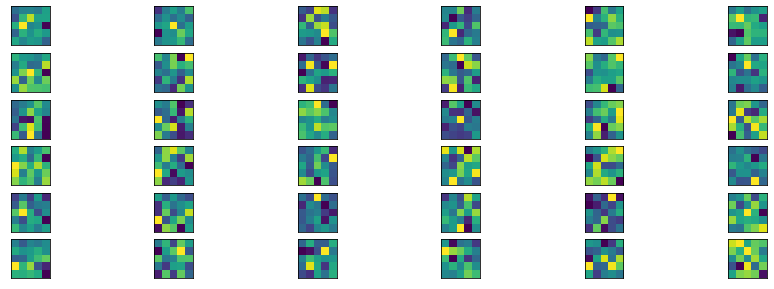

In [6]:
#filters= load_filters("D:\\MS\\Spring 2020\\Deep Learning\\Assignment 03\\")
#print(filters.shape)
filters=np.random.randn(5,5,36)
#print(new_fil.shape)
#filters=new_fil
plot_filters(filters)

In [7]:
def init_network(no_of_layers, input_dim,neurons_per_layer):
    layers_params={}

    for i in range(0,len(neurons_per_layer)):
        if i==0:
            layers_params["W1"]=np.random.randn(input_dim,neurons_per_layer[0]) 
            print("W1 Shape",layers_params["W1"].shape)
            layers_params["B1"]=np.random.randn(neurons_per_layer[0],1)
            #layers_params["B1"]=np.expand_dims(layers_params["B1"],axis=-1)
            print("B1 Shape",layers_params["B1"].shape)
            layers_params["Z1"]=np.zeros((neurons_per_layer[0],1))
            #layers_params["Z1"]=np.expand_dims(layers_params["Z1"],axis=-1)
            print("Z1 Shape",layers_params["Z1"].shape)
            layers_params["A1"]=np.zeros((neurons_per_layer[0],1))
            #layers_params["A1"]=np.expand_dims(layers_params["A1"],axis=-1)
            print("A1 Shape",layers_params["A1"].shape)
        else:
            layers_params[f"W{(i+1)}"]=np.random.randn(neurons_per_layer[i-1],neurons_per_layer[i])
            print("W"+str(i+1)+" Shape",layers_params[f"W{(i+1)}"].shape)
            layers_params[f"B{(i+1)}"]=np.random.randn(neurons_per_layer[i],1)
            #layers_params[f"B{(i+1)}"]=np.expand_dims(layers_params[f"B{(i+1)}"],axis=-1)
            print("B"+str(i+1)+" Shape",layers_params[f"B{(i+1)}"].shape)
            layers_params[f"Z{(i+1)}"]=np.zeros((neurons_per_layer[i],1))
            #layers_params[f"Z{(i+1)}"]=np.expand_dims(layers_params[f"Z{(i+1)}"],axis=-1)
            print("Z"+str(i+1)+" Shape",layers_params[f"Z{(i+1)}"].shape)
            layers_params[f"A{(i+1)}"]=np.zeros((neurons_per_layer[i],1))
            #layers_params[f"A{(i+1)}"]=np.expand_dims(layers_params[f"A{(i+1)}"],axis=-1)
            print("A"+str(i+1)+" Shape",layers_params[f"A{(i+1)}"].shape)
    return layers_params

In [8]:
def sigmoid(s):
    return 1/(1+np.exp(-s))
def sigmoid_derivative(s):
    return s*(1-s)
def MeanImageSubtraction(all_data):
    m_data=np.mean(all_data,axis=0)
    m_data=np.expand_dims(m_data,axis=-1)
    return m_data
def softmax(s):
    s=np.exp(s)
    sum_s=np.sum(s)
    #sum_s=np.expand_dims(sum_s,axis=1)
    return s/sum_s 
def one_hot_encoding(data):
    Y=[]
    for i in range(0,len(data)):
        temp=np.zeros(10,dtype=int)
        if data[i]==0:
            temp[0]=1
            Y.append(temp)
        if data[i]==1:
            temp[1]=1
            Y.append(temp)
        if data[i]==2:
            temp[2]=1
            Y.append(temp)
        if data[i]==3:
            temp[3]=1
            Y.append(temp)
        if data[i]==4:
            temp[4]=1
            Y.append(temp)
        if data[i]==5:
            temp[5]=1
            Y.append(temp)
        if data[i]==6:
            temp[6]=1
            Y.append(temp)
        if data[i]==7:
            temp[7]=1
            Y.append(temp)
        if data[i]==8:
            temp[8]=1
            Y.append(temp)
        if data[i]==9:
            temp[9]=1
            Y.append(temp)
        #print(temp)
    return np.array(Y)

def crossentropyloss(y_pred,Y):
    cel=0;
    for i in range(0,len(Y)):
        cel+= Y[i]*np.log(y_pred[i])
    return -cel

In [9]:
def feedforward(net,trainX, no_of_layers):
    net["Z1"]=np.dot(net["W1"].T,trainX) + net["B1"]
    net["A1"]=sigmoid(net["Z1"])
    for i in  range(1,no_of_layers+1):
        net[f"Z{(i+1)}"]=np.dot(net[f"W{(i+1)}"].T,net[f"A{(i)}"]) +net[f"B{(i+1)}"]
        if i<no_of_layers:
            net[f"A{(i+1)}"]=sigmoid(net[f"Z{(i+1)}"])
            continue
        net[f"A{(i+1)}"]=softmax(net[f"Z{(i+1)}"])
    return net[f"A{(i+1)}"]

In [10]:
def Backwardpropagate(sample, y_pred,Y,net,lr):
    dL_params={}
    ###for last layer 
    Y=np.expand_dims(Y,axis=-1)
    error=y_pred-Y ##error
    dL_params[f"dW{(no_of_layers+1)}"]=np.dot(net["A"+str(no_of_layers)],error.T)
    dL_params[f"dB{(no_of_layers+1)}"]=np.sum(dL_params[f"dW{(no_of_layers+1)}"].T,axis=1,keepdims=True)
    ###for intermdeiate layer
    dZ = np.multiply(sigmoid_derivative(net["A2"]),np.dot(net["W3"],error))
    dL_params[f"dW{(no_of_layers)}"]=np.dot(net["A1"],dZ.T)
    dL_params[f"dB{(no_of_layers)}"]=np.sum(dL_params[f"dW{(no_of_layers)}"].T,axis=1,keepdims=True)
    ###for first layer
    dZ1=np.multiply(sigmoid_derivative(net["A1"]),np.dot(net["W2"],dZ))
    delta=np.dot(net["W1"],dZ1)
    dL_params[f"dW{(no_of_layers-1)}"]=np.dot(sample,dZ1.T)
    dL_params[f"dB{(no_of_layers-1)}"]=np.sum(dL_params[f"dW{(no_of_layers-1)}"].T,axis=1,keepdims=True)
    return dL_params[f"dW{(no_of_layers+1)}"],dL_params[f"dB{(no_of_layers+1)}"],dL_params[f"dW{(no_of_layers)}"],dL_params[f"dB{(no_of_layers)}"],dL_params[f"dW{(no_of_layers-1)}"],dL_params[f"dB{(no_of_layers-1)}"],delta

In [11]:
def relu(s):
    return np.maximum(s,0);

def relu_derivative(s):
    s[s<=0] = 0
    s[s>0] = 1
    return s

In [12]:
def Maxpool(conv_result):
    maxID=np.zeros((conv_result.shape[0],conv_result.shape[1],conv_result.shape[2]))
    stride = 2
    fs = 2
    a=conv_result
    conv_mats = np.array([ [ [ [np.max(a[j:j+fs,k:k+fs,i]),([j,k]+np.array(np.unravel_index(np.argmax(a[j:j+fs,k:k+fs,i] , axis=None),a[j:j+fs,k:k+fs,i].shape)))] for k in range(0,a.shape[1]-fs+1,stride)] for j in range(0,a.shape[0]-fs+1,stride)] for i in range(0,a.shape[-1])])
    #conv_mats=conv_mats.reshape(conv_mats.shape[0]*conv_mats.shape[1]*conv_mats.shape[2],2)
    return conv_mats
                        

In [13]:
def Update_params(W3,B3,W2,B2,W1,B1):
    net['W3'] -= lr*W3 ###weights updation
    net['B3'] -= lr*B3###bias updation
    net['W2'] -= lr*W2 ###weights updation
    net['B2'] -= lr*B2###bias updation
    net['W1'] -= lr*W1 ###weights updation
    net['B1'] -= lr*B1###bias updation
    return

In [14]:
def accuracy(X,Y,bias):
    count=0;
    for i in range(0,len(X)):
        conv_res=conv_forward(X[i],filters)
        conv_res=conv_res+bias
        conv_res=relu(conv_res)
        pooled_result=Maxpool(conv_res)
        size=pooled_result.shape[0]*pooled_result.shape[1]*pooled_result.shape[2]
        flatt=pooled_result
        flatt=flatt.reshape(size,2)
        flatten=[]
        for val in flatt:
            flatten.append(val[0])
        flatten=np.array(flatten)
        flatten=np.expand_dims(flatten,axis=-1)
        y_pred_tst=feedforward(net,flatten,no_of_layers)
        if np.argmax(y_pred_tst)==np.argmax(Y[i]):
            count+=1
    print("Accuracy = ",count/len(Y))
    return count/len(Y)



In [15]:
def convolution(a,b):
    a=np.expand_dims(a,axis=-1)
    a=np.expand_dims(a,axis=-1)
    a=a.T
    b=b.T
    b=np.expand_dims(b,axis=1)
    inputs = torch.from_numpy(a).float()
    filters = torch.from_numpy(b).float()
    out = torch.nn.functional.conv2d(inputs, filters,stride=1,padding=0, bias=None)
    out=np.squeeze(np.array(out),axis=0)
    return out.T

In [16]:
conv_res=convolution(train_x[0],filters)
pooled_result=Maxpool(conv_res)
bias=np.random.randn(conv_res.shape[0],conv_res.shape[1],conv_res.shape[2])
no_of_layers=2;
input_dim=pooled_result.shape[0]*pooled_result.shape[1]*pooled_result.shape[2]
neurons_per_layer=[128,64,10]
net=init_network(no_of_layers,input_dim,neurons_per_layer)

W1 Shape (5184, 512)
B1 Shape (512, 1)
Z1 Shape (512, 1)
A1 Shape (512, 1)
W2 Shape (512, 256)
B2 Shape (256, 1)
Z2 Shape (256, 1)
A2 Shape (256, 1)
W3 Shape (256, 10)
B3 Shape (10, 1)
Z3 Shape (10, 1)
A3 Shape (10, 1)


In [17]:
def Mask(index,conv_res):
    maxID=np.zeros((conv_res.shape[0],conv_res.shape[1],conv_res.shape[2]))
    #print(index.shape)
    i=j=k=0 
    while(k<index.shape[0]):
        m=index[k][i][j][1][0]
        n=index[k][i][j][1][1]
        maxID[m][n][k] = 1
        j += 1
        if(j%index.shape[1]==0):
            j=0
            i+= 1
            if (i%index.shape[2]==0):
                i=0
                k+= 1
    return maxID

In [18]:
def MeanImageSubtraction(all_data):
    m_data=np.mean(all_data,axis=0)
    m_data=np.expand_dims(m_data,axis=-1)
    return m_data

In [19]:
X2=test_x
X1=train_x
X=np.concatenate((X1,X2),axis=0)
mIS=MeanImageSubtraction(X1)
X1=np.subtract(X1,mIS.T)
X2=np.subtract(X2,mIS.T)

In [20]:
indices=[]
for i in range(0,len(train_x),6000):
    indices.append(random.sample(range(i, i+6000-1),500))
a=[]
b=[]
for index in indices:
    a.append(X1[index])
    b.append(train_y[index])
X=np.array(a)
Y=np.array(b)
X=np.concatenate((X[0],X[1],X[2],X[3],X[4],X[5],X[6],X[7],X[8],X[9]),axis=0)
Y=np.concatenate((Y[0],Y[1],Y[2],Y[3],Y[4],Y[5],Y[6],Y[7],Y[8],Y[9]),axis=0)
print(X.shape)
print(Y.shape)

(5000, 28, 28)
(5000,)


In [21]:
accu_vect=[]
loss_vect=[]
lr=0.001
epochs=50

In [22]:
Y=one_hot_encoding(Y)
epochs=50
for j in range(0,epochs):
    print("Epoch #",j+1)
    loss=0
    p=np.random.permutation(len(X))
    trX=X[p]
    trY=Y[p]
    for i in range(0,len(trX)):
        print("Image #",i+1)
        conv_res=conv_forward(trX[i],filters)  #Step 1: Perform convolution
        conv_res=conv_res+bias     ###Step 2: Add bias
        conv_res=relu(conv_res)###Step 3: Perform Relu activation
        #print(conv_res.shape)
        pooled_result=Maxpool(conv_res) ### step 4: perform Max pooling
        #print("Max pool Shape",pooled_result.shape)
        maxID=Mask(pooled_result,conv_res)
        #print(maxID.shape)
        size=pooled_result.shape[0]*pooled_result.shape[1]*pooled_result.shape[2]
        flatt=pooled_result
        flatt=flatt.reshape(size,2)
        flatten=[]
        for flat in flatt:
            flatten.append(flat[0])
        flatten=np.expand_dims(np.array(flatten),axis=-1)
        y_pred=feedforward(net,flatten,no_of_layers)  ### Step 7: Send to FC layyers
        loss+=crossentropyloss(y_pred,trY[i]) #step 8: Compute loss
        W3,B3,W2,B2,W1,B1,dL=Backwardpropagate(flatten,y_pred,trY[i],net,lr)#Step 9: Backprop of FC layer(s)
        #print(dL.shape)
        dL=dL.reshape(pooled_result.shape[1],pooled_result.shape[2],pooled_result.shape[0]) #Step 10: Unflatten the flattend
        dL=np.concatenate((dL,dL),axis=1)
        dL=np.concatenate((dL,dL),axis=0)
        dL_max_pool=np.multiply(dL,maxID)  #Step 12: Backpropagation of Max-pooling layer
        dL_b=dL_max_pool                  ##Used to update bias
        dL_max_pool=np.flipud(dL_max_pool)
        dL_max_pool=np.flipud(dL_max_pool)
        #print(dL.shape)
        dL=np.multiply(dL,relu_derivative(dL_max_pool)) #Step 13: Apply derivative of Activation function
        filrs=conv_forward(trX[i],dL) #convolv with input to update filters
        if(i%10==0 and i>1):
            Update_params(W3,B3,W2,B2,W1,B1)
            filters   -=lr*filrs
            bias      -=lr*dL_b
        if(i%1000==0 and i>0):
            q=random.sample(range(0,i),300)
            valX=trX[q]
            valY=trY[q]
            print("After",i,"Images")
            accu_vect.append(accuracy(valX,valY,bias))
            print("Loss = ",loss/i)
    loss_vect.append(loss)

Epoch # 1
Image # 1
Image # 2
Image # 3
Image # 4
Image # 5
Image # 6
Image # 7
Image # 8
Image # 9
Image # 10
Image # 11
Image # 12
Image # 13
Image # 14
Image # 15
Image # 16
Image # 17
Image # 18
Image # 19
Image # 20
Image # 21
Image # 22
Image # 23
Image # 24
Image # 25
Image # 26
Image # 27
Image # 28
Image # 29
Image # 30
Image # 31
Image # 32
Image # 33
Image # 34
Image # 35
Image # 36
Image # 37
Image # 38
Image # 39
Image # 40
Image # 41
Image # 42
Image # 43
Image # 44
Image # 45
Image # 46
Image # 47
Image # 48
Image # 49
Image # 50
Image # 51
Image # 52
Image # 53
Image # 54
Image # 55
Image # 56
Image # 57
Image # 58
Image # 59
Image # 60
Image # 61
Image # 62
Image # 63
Image # 64
Image # 65
Image # 66
Image # 67
Image # 68
Image # 69
Image # 70
Image # 71
Image # 72
Image # 73
Image # 74
Image # 75
Image # 76
Image # 77
Image # 78
Image # 79
Image # 80
Image # 81
Image # 82
Image # 83
Image # 84
Image # 85
Image # 86
Image # 87
Image # 88
Image # 89
Image # 90
Image # 9

Image # 692
Image # 693
Image # 694
Image # 695
Image # 696
Image # 697
Image # 698
Image # 699
Image # 700
Image # 701
Image # 702
Image # 703
Image # 704
Image # 705
Image # 706
Image # 707
Image # 708
Image # 709
Image # 710
Image # 711
Image # 712
Image # 713
Image # 714
Image # 715
Image # 716
Image # 717
Image # 718
Image # 719
Image # 720
Image # 721
Image # 722
Image # 723
Image # 724
Image # 725
Image # 726
Image # 727
Image # 728
Image # 729
Image # 730
Image # 731
Image # 732
Image # 733
Image # 734
Image # 735
Image # 736
Image # 737
Image # 738
Image # 739
Image # 740
Image # 741
Image # 742
Image # 743
Image # 744
Image # 745
Image # 746
Image # 747
Image # 748
Image # 749
Image # 750
Image # 751
Image # 752
Image # 753
Image # 754
Image # 755
Image # 756
Image # 757
Image # 758
Image # 759
Image # 760
Image # 761
Image # 762
Image # 763
Image # 764
Image # 765
Image # 766
Image # 767
Image # 768
Image # 769
Image # 770
Image # 771
Image # 772
Image # 773
Image # 774
Imag

Image # 1341
Image # 1342
Image # 1343
Image # 1344
Image # 1345
Image # 1346
Image # 1347
Image # 1348
Image # 1349
Image # 1350
Image # 1351
Image # 1352
Image # 1353
Image # 1354
Image # 1355
Image # 1356
Image # 1357
Image # 1358
Image # 1359
Image # 1360
Image # 1361
Image # 1362
Image # 1363
Image # 1364
Image # 1365
Image # 1366
Image # 1367
Image # 1368
Image # 1369
Image # 1370
Image # 1371
Image # 1372
Image # 1373
Image # 1374
Image # 1375
Image # 1376
Image # 1377
Image # 1378
Image # 1379
Image # 1380
Image # 1381
Image # 1382
Image # 1383
Image # 1384
Image # 1385
Image # 1386
Image # 1387
Image # 1388
Image # 1389
Image # 1390
Image # 1391
Image # 1392
Image # 1393
Image # 1394
Image # 1395
Image # 1396
Image # 1397
Image # 1398
Image # 1399
Image # 1400
Image # 1401
Image # 1402
Image # 1403
Image # 1404
Image # 1405
Image # 1406
Image # 1407
Image # 1408
Image # 1409
Image # 1410
Image # 1411
Image # 1412
Image # 1413
Image # 1414
Image # 1415
Image # 1416
Image # 1417

Image # 1972
Image # 1973
Image # 1974
Image # 1975
Image # 1976
Image # 1977
Image # 1978
Image # 1979
Image # 1980
Image # 1981
Image # 1982
Image # 1983
Image # 1984
Image # 1985
Image # 1986
Image # 1987
Image # 1988
Image # 1989
Image # 1990
Image # 1991
Image # 1992
Image # 1993
Image # 1994
Image # 1995
Image # 1996
Image # 1997
Image # 1998
Image # 1999
Image # 2000
Image # 2001
After 2000 Images
Accuracy =  0.17666666666666667
Loss =  [11.67886091]
Image # 2002
Image # 2003
Image # 2004
Image # 2005
Image # 2006
Image # 2007
Image # 2008
Image # 2009
Image # 2010
Image # 2011
Image # 2012
Image # 2013
Image # 2014
Image # 2015
Image # 2016
Image # 2017
Image # 2018
Image # 2019
Image # 2020
Image # 2021
Image # 2022
Image # 2023
Image # 2024
Image # 2025
Image # 2026
Image # 2027
Image # 2028
Image # 2029
Image # 2030
Image # 2031
Image # 2032
Image # 2033
Image # 2034
Image # 2035
Image # 2036
Image # 2037
Image # 2038
Image # 2039
Image # 2040
Image # 2041
Image # 2042
Image

Image # 2597
Image # 2598
Image # 2599
Image # 2600
Image # 2601
Image # 2602
Image # 2603
Image # 2604
Image # 2605
Image # 2606
Image # 2607
Image # 2608
Image # 2609
Image # 2610
Image # 2611
Image # 2612
Image # 2613
Image # 2614
Image # 2615
Image # 2616
Image # 2617
Image # 2618
Image # 2619
Image # 2620
Image # 2621
Image # 2622
Image # 2623
Image # 2624
Image # 2625
Image # 2626
Image # 2627
Image # 2628
Image # 2629
Image # 2630
Image # 2631
Image # 2632
Image # 2633
Image # 2634
Image # 2635
Image # 2636
Image # 2637
Image # 2638
Image # 2639
Image # 2640
Image # 2641
Image # 2642
Image # 2643
Image # 2644
Image # 2645
Image # 2646
Image # 2647
Image # 2648
Image # 2649
Image # 2650
Image # 2651
Image # 2652
Image # 2653
Image # 2654
Image # 2655
Image # 2656
Image # 2657
Image # 2658
Image # 2659
Image # 2660
Image # 2661
Image # 2662
Image # 2663
Image # 2664
Image # 2665
Image # 2666
Image # 2667
Image # 2668
Image # 2669
Image # 2670
Image # 2671
Image # 2672
Image # 2673

Image # 3223
Image # 3224
Image # 3225
Image # 3226
Image # 3227
Image # 3228
Image # 3229
Image # 3230
Image # 3231
Image # 3232
Image # 3233
Image # 3234
Image # 3235
Image # 3236
Image # 3237
Image # 3238
Image # 3239
Image # 3240
Image # 3241
Image # 3242
Image # 3243
Image # 3244
Image # 3245
Image # 3246
Image # 3247
Image # 3248
Image # 3249
Image # 3250
Image # 3251
Image # 3252
Image # 3253
Image # 3254
Image # 3255
Image # 3256
Image # 3257
Image # 3258
Image # 3259
Image # 3260
Image # 3261
Image # 3262
Image # 3263
Image # 3264
Image # 3265
Image # 3266
Image # 3267
Image # 3268
Image # 3269
Image # 3270
Image # 3271
Image # 3272
Image # 3273
Image # 3274
Image # 3275
Image # 3276
Image # 3277
Image # 3278
Image # 3279
Image # 3280
Image # 3281
Image # 3282
Image # 3283
Image # 3284
Image # 3285
Image # 3286
Image # 3287
Image # 3288
Image # 3289
Image # 3290
Image # 3291
Image # 3292
Image # 3293
Image # 3294
Image # 3295
Image # 3296
Image # 3297
Image # 3298
Image # 3299

Image # 3854
Image # 3855
Image # 3856
Image # 3857
Image # 3858
Image # 3859
Image # 3860
Image # 3861
Image # 3862
Image # 3863
Image # 3864
Image # 3865
Image # 3866
Image # 3867
Image # 3868
Image # 3869
Image # 3870
Image # 3871
Image # 3872
Image # 3873
Image # 3874
Image # 3875
Image # 3876
Image # 3877
Image # 3878
Image # 3879
Image # 3880
Image # 3881
Image # 3882
Image # 3883
Image # 3884
Image # 3885
Image # 3886
Image # 3887
Image # 3888
Image # 3889
Image # 3890
Image # 3891
Image # 3892
Image # 3893
Image # 3894
Image # 3895
Image # 3896
Image # 3897
Image # 3898
Image # 3899
Image # 3900
Image # 3901
Image # 3902
Image # 3903
Image # 3904
Image # 3905
Image # 3906
Image # 3907
Image # 3908
Image # 3909
Image # 3910
Image # 3911
Image # 3912
Image # 3913
Image # 3914
Image # 3915
Image # 3916
Image # 3917
Image # 3918
Image # 3919
Image # 3920
Image # 3921
Image # 3922
Image # 3923
Image # 3924
Image # 3925
Image # 3926
Image # 3927
Image # 3928
Image # 3929
Image # 3930

Image # 4479
Image # 4480
Image # 4481
Image # 4482
Image # 4483
Image # 4484
Image # 4485
Image # 4486
Image # 4487
Image # 4488
Image # 4489
Image # 4490
Image # 4491
Image # 4492
Image # 4493
Image # 4494
Image # 4495
Image # 4496
Image # 4497
Image # 4498
Image # 4499
Image # 4500
Image # 4501
Image # 4502
Image # 4503
Image # 4504
Image # 4505
Image # 4506
Image # 4507
Image # 4508
Image # 4509
Image # 4510
Image # 4511
Image # 4512
Image # 4513
Image # 4514
Image # 4515
Image # 4516
Image # 4517
Image # 4518
Image # 4519
Image # 4520
Image # 4521
Image # 4522
Image # 4523
Image # 4524
Image # 4525
Image # 4526
Image # 4527
Image # 4528
Image # 4529
Image # 4530
Image # 4531
Image # 4532
Image # 4533
Image # 4534
Image # 4535
Image # 4536
Image # 4537
Image # 4538
Image # 4539
Image # 4540
Image # 4541
Image # 4542
Image # 4543
Image # 4544
Image # 4545
Image # 4546
Image # 4547
Image # 4548
Image # 4549
Image # 4550
Image # 4551
Image # 4552
Image # 4553
Image # 4554
Image # 4555

Image # 127
Image # 128
Image # 129
Image # 130
Image # 131
Image # 132
Image # 133
Image # 134
Image # 135
Image # 136
Image # 137
Image # 138
Image # 139
Image # 140
Image # 141
Image # 142
Image # 143
Image # 144
Image # 145
Image # 146
Image # 147
Image # 148
Image # 149
Image # 150
Image # 151
Image # 152
Image # 153
Image # 154
Image # 155
Image # 156
Image # 157
Image # 158
Image # 159
Image # 160
Image # 161
Image # 162
Image # 163
Image # 164
Image # 165
Image # 166
Image # 167
Image # 168
Image # 169
Image # 170
Image # 171
Image # 172
Image # 173
Image # 174
Image # 175
Image # 176
Image # 177
Image # 178
Image # 179
Image # 180
Image # 181
Image # 182
Image # 183
Image # 184
Image # 185
Image # 186
Image # 187
Image # 188
Image # 189
Image # 190
Image # 191
Image # 192
Image # 193
Image # 194
Image # 195
Image # 196
Image # 197
Image # 198
Image # 199
Image # 200
Image # 201
Image # 202
Image # 203
Image # 204
Image # 205
Image # 206
Image # 207
Image # 208
Image # 209
Imag

Image # 810
Image # 811
Image # 812
Image # 813
Image # 814
Image # 815
Image # 816
Image # 817
Image # 818
Image # 819
Image # 820
Image # 821
Image # 822
Image # 823
Image # 824
Image # 825
Image # 826
Image # 827
Image # 828
Image # 829
Image # 830
Image # 831
Image # 832
Image # 833
Image # 834
Image # 835
Image # 836
Image # 837
Image # 838
Image # 839
Image # 840
Image # 841
Image # 842
Image # 843
Image # 844
Image # 845
Image # 846
Image # 847
Image # 848
Image # 849
Image # 850
Image # 851
Image # 852
Image # 853
Image # 854
Image # 855
Image # 856
Image # 857
Image # 858
Image # 859
Image # 860
Image # 861
Image # 862
Image # 863
Image # 864
Image # 865
Image # 866
Image # 867
Image # 868
Image # 869
Image # 870
Image # 871
Image # 872
Image # 873
Image # 874
Image # 875
Image # 876
Image # 877
Image # 878
Image # 879
Image # 880
Image # 881
Image # 882
Image # 883
Image # 884
Image # 885
Image # 886
Image # 887
Image # 888
Image # 889
Image # 890
Image # 891
Image # 892
Imag

Image # 1450
Image # 1451
Image # 1452
Image # 1453
Image # 1454
Image # 1455
Image # 1456
Image # 1457
Image # 1458
Image # 1459
Image # 1460
Image # 1461
Image # 1462
Image # 1463
Image # 1464
Image # 1465
Image # 1466
Image # 1467
Image # 1468
Image # 1469
Image # 1470
Image # 1471
Image # 1472
Image # 1473
Image # 1474
Image # 1475
Image # 1476
Image # 1477
Image # 1478
Image # 1479
Image # 1480
Image # 1481
Image # 1482
Image # 1483
Image # 1484
Image # 1485
Image # 1486
Image # 1487
Image # 1488
Image # 1489
Image # 1490
Image # 1491
Image # 1492
Image # 1493
Image # 1494
Image # 1495
Image # 1496
Image # 1497
Image # 1498
Image # 1499
Image # 1500
Image # 1501
Image # 1502
Image # 1503
Image # 1504
Image # 1505
Image # 1506
Image # 1507
Image # 1508
Image # 1509
Image # 1510
Image # 1511
Image # 1512
Image # 1513
Image # 1514
Image # 1515
Image # 1516
Image # 1517
Image # 1518
Image # 1519
Image # 1520
Image # 1521
Image # 1522
Image # 1523
Image # 1524
Image # 1525
Image # 1526

Image # 2075
Image # 2076
Image # 2077
Image # 2078
Image # 2079
Image # 2080
Image # 2081
Image # 2082
Image # 2083
Image # 2084
Image # 2085
Image # 2086
Image # 2087
Image # 2088
Image # 2089
Image # 2090
Image # 2091
Image # 2092
Image # 2093
Image # 2094
Image # 2095
Image # 2096
Image # 2097
Image # 2098
Image # 2099
Image # 2100
Image # 2101
Image # 2102
Image # 2103
Image # 2104
Image # 2105
Image # 2106
Image # 2107
Image # 2108
Image # 2109
Image # 2110
Image # 2111
Image # 2112
Image # 2113
Image # 2114
Image # 2115
Image # 2116
Image # 2117
Image # 2118
Image # 2119
Image # 2120
Image # 2121
Image # 2122
Image # 2123
Image # 2124
Image # 2125
Image # 2126
Image # 2127
Image # 2128
Image # 2129
Image # 2130
Image # 2131
Image # 2132
Image # 2133
Image # 2134
Image # 2135
Image # 2136
Image # 2137
Image # 2138
Image # 2139
Image # 2140
Image # 2141
Image # 2142
Image # 2143
Image # 2144
Image # 2145
Image # 2146
Image # 2147
Image # 2148
Image # 2149
Image # 2150
Image # 2151

KeyboardInterrupt: 

In [ ]:
plt.plot(loss_vect)

In [ ]:
plt.plot(accu_vect)

In [ ]:
plot_filters(filters)